In [1]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from spglm.iwls import _compute_betas_gwr, iwls  
from spglm.family import Gaussian
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor

import warnings
warnings.filterwarnings('ignore')

np.set_printoptions(precision=3, suppress=True)

In [14]:
# Simulate S1 and S2
def simulate_S1_S2(num_points1, num_points2):
    np.random.seed(26)
    locations1 = np.random.rand(num_points1, 2) * 100
    centers = [(30, 30), (70, 70), (30, 70), (70, 30)]
    locations2, _ = make_blobs(n_samples=num_points2, centers=centers, cluster_std=10.0, random_state=26)
    locations2 = np.clip(locations2, 0, 100)
    s1 = np.random.normal(50, 20, num_points1)
    s2 = np.random.normal(100, 50, num_points2)
    return s1, locations1, s2, locations2

S1, loc1, S2, loc2 = simulate_S1_S2(200, 350)

# Gaussian Random Field Beta Surface
def create_gaussian_random_field_surface(locations, length_scale=20.0, seed=42):
    np.random.seed(seed)
    # Use a Gaussian process to generate the field
    kernel = RBF(length_scale=length_scale)
    gp = GaussianProcessRegressor(kernel=kernel, random_state=seed)
    
    # Create the Gaussian random field by predicting on the grid
    B = gp.sample_y(locations, random_state=seed).flatten()
    return B

# Create beta surface
def create_beta_surface(locations, complexity='uniform'):
    x, y = locations[:, 0], locations[:, 1]
    if complexity == 'uniform':
        B = x / 10 + y / 10
    elif complexity == 'local':
        B = np.sin(x/10) * np.cos(y/10) + (x-50)**2/100 + (y-50)**2/100
    return B

# Define true beta surface
B = create_beta_surface(loc1, complexity='uniform')
# B = create_gaussian_random_field_surface(loc1)


# Generate y values
nbrs_S2 = NearestNeighbors(n_neighbors=35).fit(loc2)
smoothed_S2_to_S1 = np.zeros(len(S1))
for i in range(len(S1)):
    distances_S1_to_S2, indices_S1_to_S2 = nbrs_S2.kneighbors([loc1[i]])
    smoothed_S2_to_S1[i] = np.mean(S2[indices_S1_to_S2[0]])

y = B * smoothed_S2_to_S1

In [15]:
# Gaussian family initialization
family = Gaussian()

In [16]:
def calculate_aicc(n, log_likelihood, tr_S):
    """GWR-style AICc calculation using log-likelihood and trace of the hat matrix (tr_S)."""
    aic = -2 * log_likelihood + 2 * (tr_S + 1)
    aicc = aic + (2 * tr_S * (tr_S + 1)) / (n - tr_S - 1)
    return aicc

def log_likelihood_gaussian(residuals, n):
    """Calculate log-likelihood for Gaussian model."""
    sigma2 = np.sum(residuals**2) / n
    log_likelihood = -0.5 * n * (np.log(2 * np.pi * sigma2) + 1)
    return log_likelihood

def plot_true_and_recovered(true, recovered, coord):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(coord[:,0], coord[:, 1], c=true, cmap='Reds', alpha=0.6)
    plt.xlabel('Index')
    plt.ylabel('True B Values')
    plt.colorbar(label='Beta Value')
    plt.title('True B Values')
    
    plt.subplot(1, 2, 2)
    plt.scatter(coord[:,0], coord[:, 1], c=recovered, cmap='Reds', alpha=0.6)
    plt.xlabel('Index')
    plt.ylabel('recovered B Values')
    plt.colorbar(label='Beta Value')
    plt.title('recovered B Values')
    
    plt.tight_layout()
    plt.show()
    

In [17]:
def perform_local_regression_using_betas_gwr(n_neighbor_est, loc1, loc2, S2, y):
    recovered_betas = np.zeros(len(S1))
    residuals = np.zeros(len(S1))
    N = len(S1)

    R = np.zeros((N, N))
    S = np.zeros((N, N))

    for i in range(len(S1)):
        # Find neighbors in S2 for current S1_i for smoothing
        nbrs_S2 = NearestNeighbors(n_neighbors=n_neighbor_est).fit(loc2)
        distances_S1_to_S2, indices_S1_to_S2 = nbrs_S2.kneighbors([loc1[i]])
        
        local_X = []
        weights_X = []
        
        # Smooth S2 onto S1 within the local regression function
        for j, neighbor_index_S2 in enumerate(indices_S1_to_S2[0]):
            dist_j_to_i = distances_S1_to_S2[0][j]
            weight = np.exp(-0.5 * (dist_j_to_i / 10)**2)
            local_X.append(S2[neighbor_index_S2])
            weights_X.append(weight)

        local_X = np.array(local_X)
        weights_X = np.array(weights_X)
        weighted_X_i = np.sum(local_X * weights_X) / np.sum(weights_X)

        # Local regression using weighted S2 data at S1_i
        nbrs_S1 = NearestNeighbors(n_neighbors=n_neighbor_est).fit(loc1)
        distances, indices = nbrs_S1.kneighbors([loc1[i]])

        y_neighbors = y[indices[0]].reshape(-1, 1)
        X_neighbors = weighted_X_i * np.ones(len(indices[0])).reshape(-1, 1)

        weights_y = np.exp(-0.5 * (distances[0] / 10)**2).reshape(-1, 1)
        W_y = np.sqrt(weights_y)  # These weights will be used in iwls routine

        # Use _compute_betas_gwr
        # betas, xtx_inv_xt = _compute_betas_gwr(y_neighbors, X_neighbors, W_y)
        rslt = iwls(y_neighbors, X_neighbors, family, None, None, None, 1.0e-5, 20, wi=W_y)

        recovered_betas[i] = rslt[0]
        
        ri = np.dot(X_neighbors, rslt[5])
    
        R[i, indices[0]] = ri[0]
        S[i, indices[0]] = ri[0] * rslt[4].flatten()
        
        y_pred_i = np.dot(X_neighbors[0], rslt[0])
        residuals[i] = y[i] - y_pred_i
    
    # Calculate trace of S
    tr_S = np.trace(S)


    log_likelihood = log_likelihood_gaussian(residuals, len(S1))
    aicc = calculate_aicc(len(S1), log_likelihood, tr_S)
    
    return recovered_betas, aicc

In [22]:
# Define range for number of neighbors
neighbors_values = list(range(2, 100, 5))
best_aicc = float('inf')
best_neighbors = None
recovered_betas_best = None

aicc_values = []

# Iterate over neighbor values
for n_neighbors in neighbors_values:
    recovered_betas, aicc = perform_local_regression_using_betas_gwr(n_neighbors, loc1, loc2, S2, y)
    aicc_values.append(aicc)
    if aicc < best_aicc:
        best_aicc = aicc
        best_neighbors = n_neighbors
        recovered_betas_best = recovered_betas

print(f"Optimal number of neighbors: {best_neighbors}")
print(f"Best AICc: {best_aicc:.2f}")

Optimal number of neighbors: 2
Best AICc: 2072.82


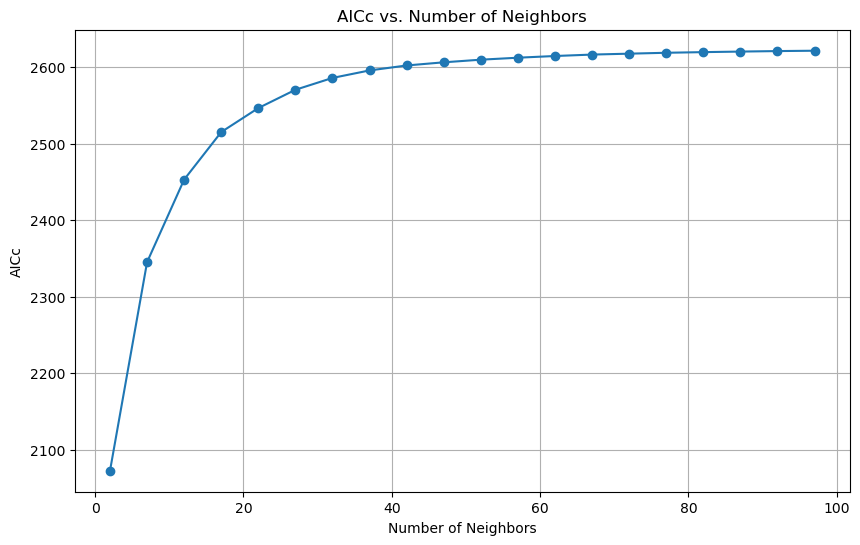

In [23]:
# Plotting AICc vs. number of neighbors
plt.figure(figsize=(10, 6))
plt.plot(neighbors_values, aicc_values, marker='o')
plt.xlabel('Number of Neighbors')
plt.ylabel('AICc')
plt.title('AICc vs. Number of Neighbors')
plt.grid(True)
plt.show()

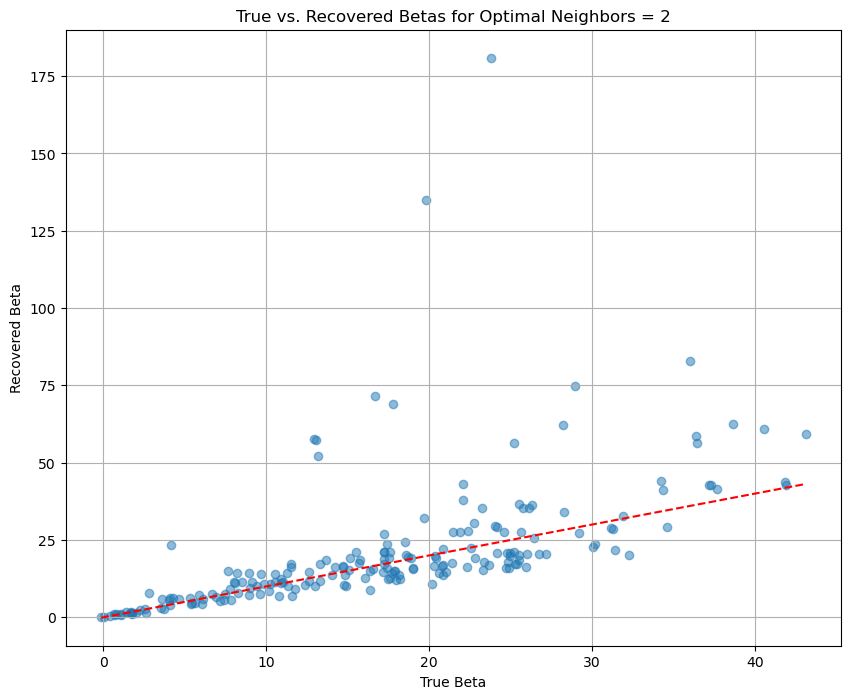

In [24]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors
plt.figure(figsize=(10, 8))
plt.scatter(B, recovered_betas_best, alpha=0.5)
plt.plot([B.min(), B.max()], [B.min(), B.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title(f'True vs. Recovered Betas for Optimal Neighbors = {best_neighbors}')
plt.grid(True)
plt.show()

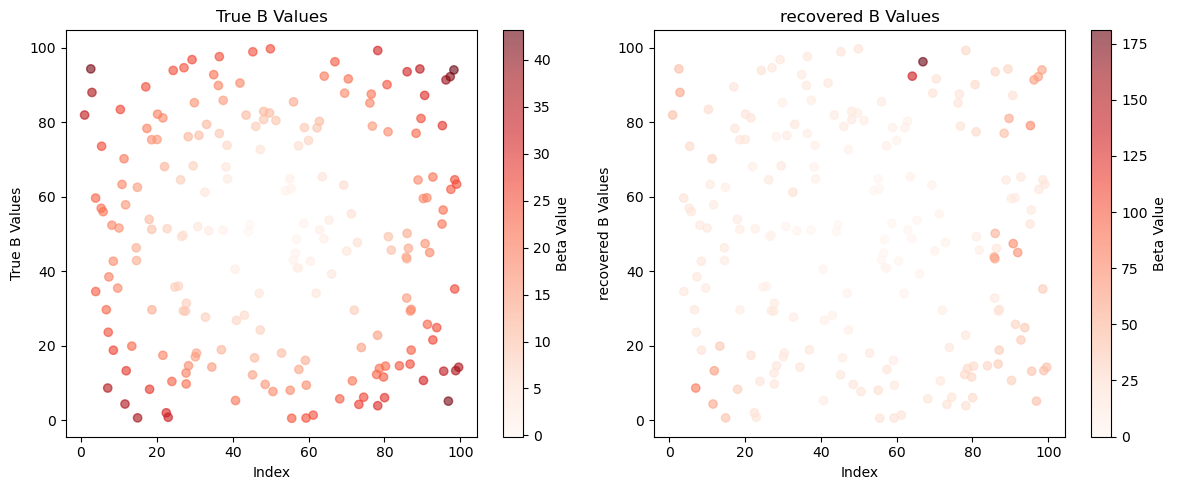

In [25]:
plot_true_and_recovered(B, recovered_betas_best, loc1)

## Test gwr recoverability 

In [119]:
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.diagnostics import get_AICc

In [120]:
gwr_X = smoothed_S2_to_S1.reshape(-1, 1)
gwr_y = y.reshape(-1, 1)
coords = loc1

In [121]:
selector = Sel_BW(coords, gwr_y, gwr_X, constant=True)
optimal_bandwidth = selector.search()
optimal_bandwidth

45.0

In [122]:
coords.shape, gwr_y.shape, gwr_X.shape

((200, 2), (200, 1), (200, 1))

In [123]:
gwr_model = GWR(coords, gwr_y, gwr_X, 43, constant=False)

In [124]:
result = gwr_model.fit()

In [125]:
result.summary()

Model type                                                         Gaussian
Number of observations:                                                 200
Number of covariates:                                                     1

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                       31945783.736
Log-likelihood:                                                   -1481.911
AIC:                                                               2965.822
AICc:                                                              2967.883
BIC:                                                           31944729.371
R2:                                                                  -0.020
Adj. R2:                                                             -0.020

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [126]:
recovered_betas_gwr = result.params#[:,1]

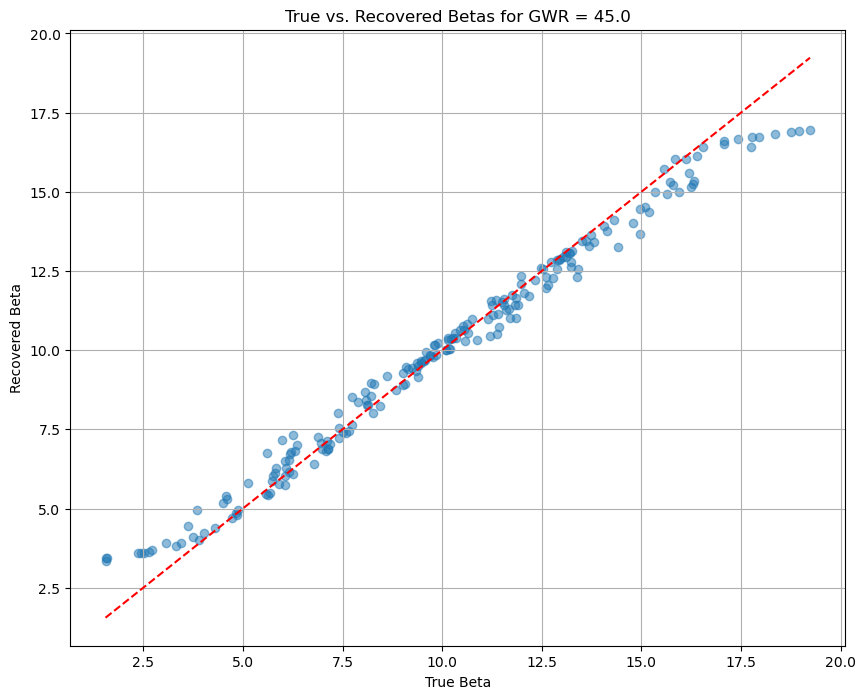

In [127]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors
plt.figure(figsize=(10, 8))
plt.scatter(B, recovered_betas_gwr, alpha=0.5)
plt.plot([B.min(), B.max()], [B.min(), B.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title(f'True vs. Recovered Betas for GWR = {optimal_bandwidth}')
plt.grid(True)
plt.show()

In [128]:
aicc_gwr = []
params = []
bwvalue = list(range(3, 30, 2))
for i in bwvalue:
    model = GWR(coords, gwr_y, gwr_X, i, constant=False).fit()
    params.append(model.params)
    aicc_gwr.append(model.aicc)

In [129]:
dict_aicc = dict(zip(bwvalue, aicc_gwr))

In [130]:
min(dict_aicc, key=dict_aicc.get)

9

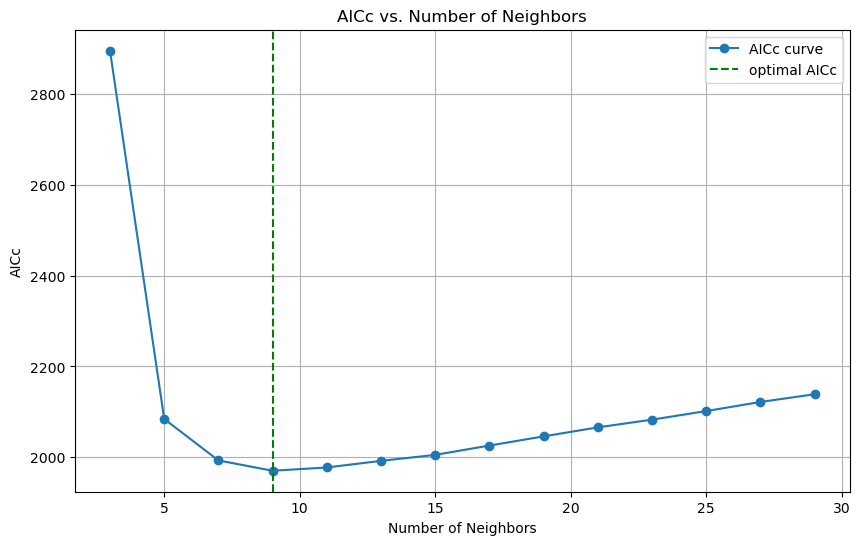

In [131]:
# Plotting AICc vs. number of neighbors
plt.figure(figsize=(10, 6))
plt.plot(bwvalue, aicc_gwr, marker='o', label='AICc curve')
plt.axvline(min(dict_aicc, key=dict_aicc.get), linestyle='--', color='green', label='optimal AICc')
plt.xlabel('Number of Neighbors')
plt.ylabel('AICc')
plt.legend()
plt.title('AICc vs. Number of Neighbors')
plt.grid(True)
plt.show()

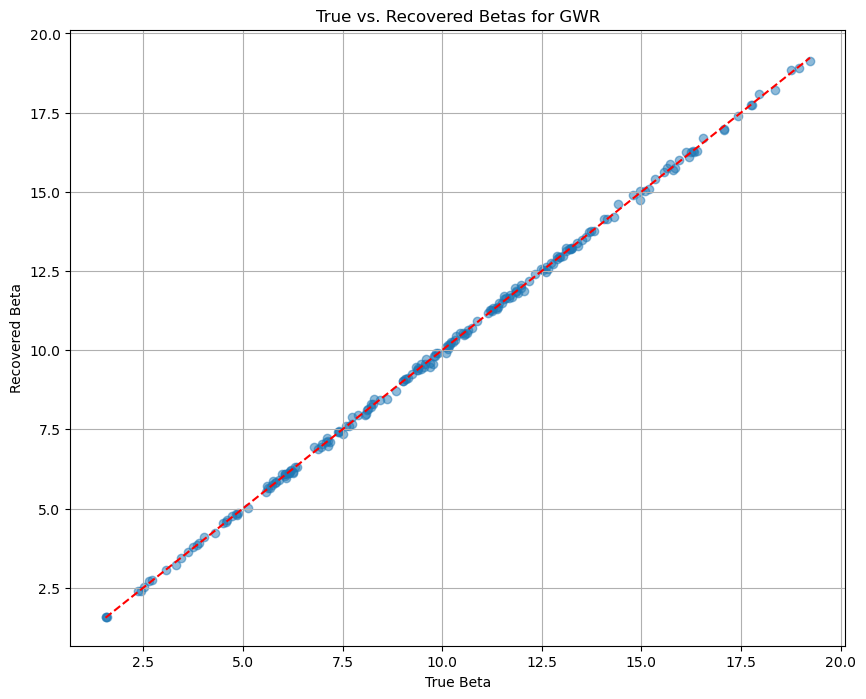

In [132]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors
plt.figure(figsize=(10, 8))
plt.scatter(B, params[0],
            alpha=0.5)
plt.plot([B.min(), B.max()], [B.min(), B.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title("True vs. Recovered Betas for GWR")
plt.grid(True)
plt.show()

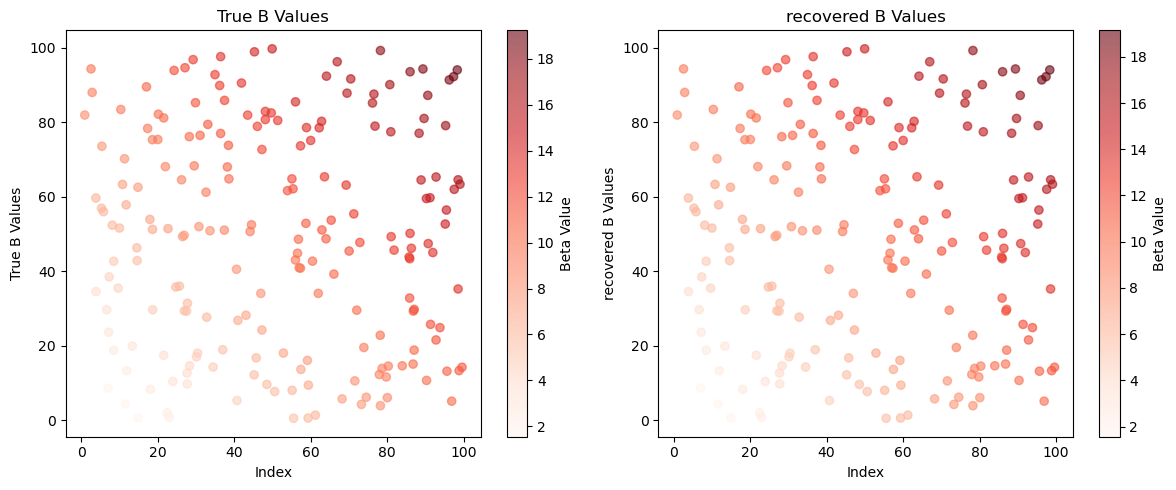

In [133]:
plot_true_and_recovered(B, params[0], loc1)

In [134]:
# Test Case


# # def perform_local_regression_using_betas_gwr(n_neighbor_est, loc1, loc2, S2, y):
# recovered_betas = np.zeros(len(S1))
# residuals = np.zeros(len(S1))
# tr_S = 0  # To accumulate trace of the hat matrix

# N = len(S1)

# R = np.zeros((N, N))
# S = np.zeros((N, N))

# for i in range(len(S1)):
#     # Find neighbors in S2 for current S1_i for smoothing
#     nbrs_S2 = NearestNeighbors(n_neighbors=20).fit(loc2)
#     distances_S1_to_S2, indices_S1_to_S2 = nbrs_S2.kneighbors([loc1[i]])
    
#     local_X = []
#     weights_X = []
    
#     # Smooth S2 onto S1 within the local regression function
#     for j, neighbor_index_S2 in enumerate(indices_S1_to_S2[0]):
#         dist_j_to_i = distances_S1_to_S2[0][j]
#         weight = np.exp(-0.5 * (dist_j_to_i / 10)**2)
#         local_X.append(S2[neighbor_index_S2])
#         weights_X.append(weight)

#     local_X = np.array(local_X)
#     weights_X = np.array(weights_X)
#     weighted_X_i = np.sum(local_X * weights_X) / np.sum(weights_X)

#     # Local regression using weighted S2 data at S1_i
#     nbrs_S1 = NearestNeighbors(n_neighbors=20).fit(loc1)
#     distances, indices = nbrs_S1.kneighbors([loc1[i]])

#     y_neighbors = y[indices[0]].reshape(-1, 1)
#     X_neighbors = weighted_X_i * np.ones(len(indices[0])).reshape(-1, 1)

#     weights_y = np.exp(-0.5 * (distances[0] / 10)**2).reshape(-1, 1)
#     W_y = np.sqrt(weights_y)  # These weights will be used in _compute_betas_gwr routine

#     # Use _compute_betas_gwr
#     # betas, xtx_inv_xt = _compute_betas_gwr(y_neighbors, X_neighbors, W_y)
#     rslt = iwls(y_neighbors, X_neighbors, family, None, None, None, 1.0e-5, 20, wi=W_y)

#     recovered_betas[i] = rslt[0].flatten()
#     ri = np.dot(X_neighbors, rslt[5])

#     R[i, indices[0]] = ri[0]
#     S[i, indices[0]] = ri[0] * rslt[4].flatten()
    
#     # y_pred_i = np.dot(X_neighbors[0], rslt[0])
#     y_pred_i = rslt[1][0]
#     residuals[i] = y[i] - y_pred_i

#     # Calculate trace of S
#     tr_S = np.trace(S)

# log_likelihood = log_likelihood_gaussian(residuals, N)
# aicc = calculate_aicc(N, log_likelihood, tr_S)
